In [71]:
#Estudo de caso 5 do curso de Introduação à Ciência de Dados Aplicada à Cibersegurança

#Importando bibliotecas básicas

import numpy as np # vetores e matrizes 
import pandas as pd # processamento dos dados, arquivo CSV I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [72]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

In [73]:
labelsDf = pd.read_csv("../../chatgpt_daily_tweets.csv")

In [74]:
noViews = labelsDf[labelsDf['impression_count'] < 1]
noViews.head()

,tweet_id,tweet_created,tweet_extracted,text,lang,user_id,user_name,user_username,user_location,user_description,user_created,user_followers_count,user_following_count,user_tweet_count,user_verified,source,retweet_count,like_count,reply_count,impression_count
0,1.642889622681432e+18,2023-04-03 13:59:44+00:00,2023-04-08 01:07:02.538242,RT @jexep: เทคนิคฝึกภาษากับ ChatGPT ที่ผมลอง (...,th,4706577259,👷🏼 ♡ #GOT7,BPawarisa1a,ในใจJacksonwang,@JacksonWang852 ➖ รีวิว #รีวิวแบมพี #แบมพีอัพเ...,2016-01-04 02:27:33+00:00,1293.0,445.0,87051.0,False,NaN,13640.0,0.0,0.0,0.0
2,1.6427385624866693e+18,2023-04-03 03:59:28+00:00,2023-04-08 01:06:52.504868,RT @DarrellLerner: ChatGPT Plugins are the fas...,en,2383245894,pk,pradeep42329225,India,💐💐।।जय श्री महाकाल।।💐💐,2014-03-11 06:04:10+00:00,269.0,4141.0,3816.0,False,NaN,628.0,0.0,0.0,0.0
4,1.642708351690711e+18,2023-04-03 01:59:25+00:00,2023-04-08 01:06:50.638068,"🔥Hey Guys, #ZenithSwap has launched at just $ ...",en,1311403370670960640,Human Being 🇨🇳🇸🇬🇻🇳,KiarostamiBeing,"Chicago, IL",Freedom is the Recognition of Necessity • Mark...,2020-09-30 20:32:00+00:00,447.0,419.0,12949.0,False,NaN,0.0,0.0,0.0,0.0
5,1.6428593561893274e+18,2023-04-03 11:59:28+00:00,2023-04-08 01:07:00.375167,RT @sinsonetwork: Now! Join #SINSO DataLand^Ch...,en,462142717,MokoHaram,holymoko,Zambia mufulira,Public faker🍂,2012-01-12 16:25:12+00:00,2286.0,982.0,20438.0,False,NaN,270.0,0.0,0.0,0.0
6,1.6426932602789274e+18,2023-04-03 00:59:27+00:00,2023-04-08 01:06:49.813797,RT @igz0: 著者がジョン・フォン・ノイマンの本を読んだことあるけど、脳がコンピュータ...,ja,1642685174176526337,Inventor2525,inventor2525,South West Michigan,"Half crazy roboticist (soft and ag), dabbling ...",2023-04-03 00:27:32+00:00,3.0,15.0,9.0,False,NaN,876.0,0.0,0.0,0.0


In [75]:
# create new df with tweet, id and label (bot or not)
df = pd.DataFrame(columns=['tweet', 'id', 'label'])
df['tweet'] = noViews['text']
df['id'] = noViews['user_id']
# make all rows 1 (bot)
df['label'] = 1

In [76]:
# drop every row with the word RT
df = df[~df['tweet'].str.contains("RT")]

In [77]:
# create new df with tweet, id and label (bot or not)
df2 = pd.DataFrame(columns=['tweet', 'id', 'label'])
df2['tweet'] = labelsDf['text']
df2['id'] = labelsDf['user_id']
# make all rows 0 (not bot)
df2['label'] = 0

In [78]:
# take all df rows from labelsDf 
df2 = df2[~df2['tweet'].isin(df['tweet'])]

In [79]:
# select only 2000 rows from df2
df2 = df2.sample(n=2000)

In [80]:
mergedDf = pd.concat([df, df2])


In [81]:
#shuffe rows
mergedDf = mergedDf.sample(frac=1).reset_index(drop=True)

In [82]:
# emit csv
mergedDf.to_csv('botClassificator.csv', index=False)

In [83]:
lamitizer = WordNetLemmatizer()

In [84]:
train = []
for i in range(len(mergedDf)):
    review = re.sub('[^a-zA-Z]', ' ', mergedDf['tweet'][i])
    review = review.lower()
    review = review.split()
    review = [lamitizer.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    train.append(review)

In [85]:
# Criando o documento de treino

couvec = CountVectorizer(max_features=5000)
x = couvec.fit_transform(train).toarray()

In [86]:
y = pd.get_dummies(mergedDf['label'])
y = y.iloc[:,1].values

In [87]:
#Dividindo a base em treino e teste
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.20, random_state = 42)

In [88]:
# número de características ou tokens
trained_features = couvec.get_feature_names_out()
print("Número de características vetorizadas:", len(trained_features))
print("Exemplos de características treinadas:", trained_features[1:10])

Número de características vetorizadas: 5000
Exemplos de características treinadas: ['aakashg' 'abhishek' 'ability' 'able' 'abskoop' 'academic' 'acc' 'access'
 'according']


In [89]:
#initialize multiple classification models
svc = SVC(kernel='sigmoid', gamma=1.0)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=42)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=42)

In [90]:
#create a dictionary of variables and models
clfs = {'SVC' : svc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}

In [91]:
#fit the data onto the models
def train(clf, features, targets):
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

In [92]:
pred_scores_word_vectors = []
cm_all = []
recall_all = []
precision_all = []
for k,v in clfs.items():
    train(v, train_x, train_y)
    pred = predict(v, test_x)
    cm = metrics.confusion_matrix(test_y, pred)
    recall = metrics.recall_score(test_y, pred)
    precision = metrics.precision_score(test_y, pred)
    cm_all.append((k, cm))
    recall_all.append((k, recall))
    precision_all.append((k, precision))
    pred_scores_word_vectors.append((k, [accuracy_score(test_y , pred)]))

In [93]:
def print_all():
    print(recall_all)
    print(precision_all)
    print(cm_all)
    print(pred_scores_word_vectors)

In [94]:
print_all()

[('SVC', 0.20930232558139536), ('NB', 0.8023255813953488), ('DT', 0.813953488372093), ('LR', 0.6744186046511628), ('RF', 0.7674418604651163)]
[('SVC', 0.2571428571428571), ('NB', 0.6330275229357798), ('DT', 0.693069306930693), ('LR', 0.8169014084507042), ('RF', 0.7252747252747253)]
[('SVC', array([[347,  52],
       [ 68,  18]])), ('NB', array([[359,  40],
       [ 17,  69]])), ('DT', array([[368,  31],
       [ 16,  70]])), ('LR', array([[386,  13],
       [ 28,  58]])), ('RF', array([[374,  25],
       [ 20,  66]]))]
[('SVC', [0.7525773195876289]), ('NB', [0.8824742268041237]), ('DT', [0.9030927835051547]), ('LR', [0.9154639175257732]), ('RF', [0.9072164948453608])]


In [95]:
labels_prob = lrc.predict_proba(test_x)[:, 1]
precisions, recalls, thresholds = metrics.precision_recall_curve(test_y, labels_prob)

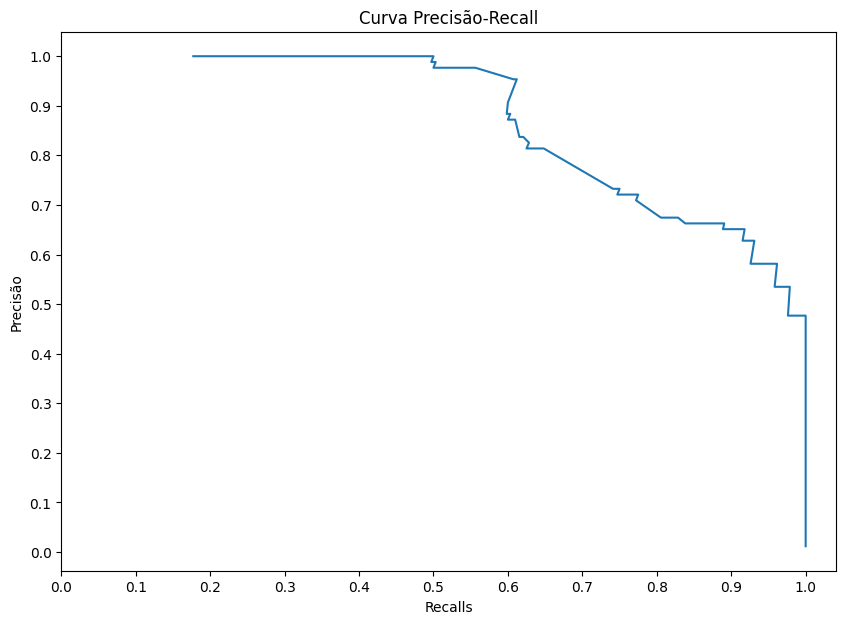

In [96]:
# Plotando a curva precisão-recall 
plt.figure(figsize=(10, 7))
plt.plot(precisions[:-1], recalls[:-1])
plt.xlabel("Recalls")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Precisão")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Curva Precisão-Recall")
plt.show()

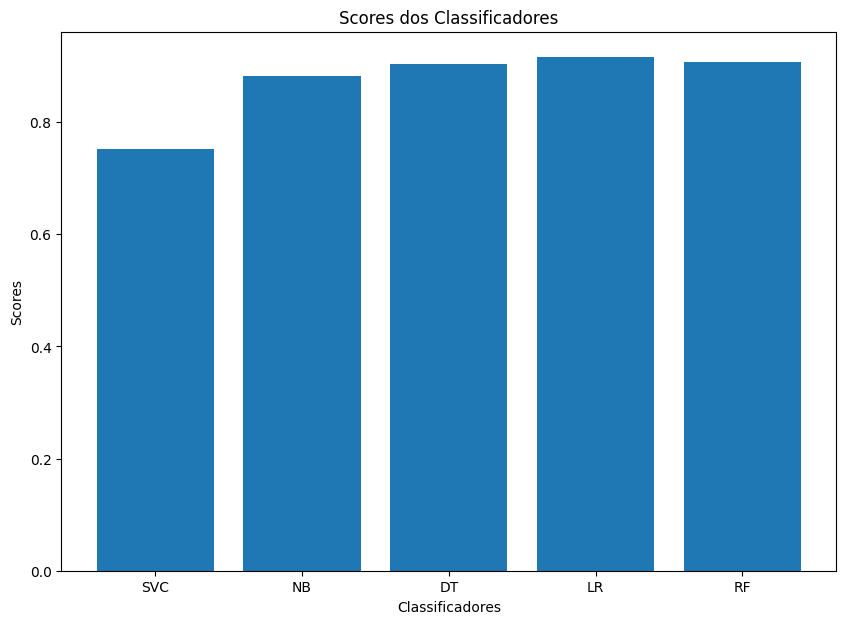

In [97]:
#plot bar graph of various models and their prediction scores
index = np.arange(len(pred_scores_word_vectors))
fig, ax = plt.subplots(figsize=(10,7))
pred_scores = [i[1] for i in pred_scores_word_vectors]
pred_scores = np.array(pred_scores).flatten()
plt.bar(index, pred_scores)
plt.xticks(index, [i[0] for i in pred_scores_word_vectors])
plt.ylabel('Scores')
plt.xlabel('Classificadores')
plt.title('Scores dos Classificadores')
plt.show()


In [98]:
df = pd.read_csv("../../cleaned.csv")

/var/folders/vz/n6zw0k5d2lq0xf_c45lm2sb40000gn/T/ipykernel_13349/1552240925.py:1: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../cleaned.csv")


In [99]:

# # Preprocessing the dataframe
# df['tweet'] = df['tweet'].apply(lambda x: ' '.join([lamitizer.lemmatize(word) for word in x.lower().split() if word not in stopwords.words('english')]))

# # Transform the data using CountVectorizer
# df_vec = couvec.transform(df['tweet']).toarray()

# # Make predictions with RandomForestClassifier
# preds = rfc.predict(df_vec)

# # Add the predictions to the dataframe
# df['is_bot'] = preds

# # Keep only the rows where 'is_bot' is 0 (not a bot)
# df_cleaned = df[df['is_bot'] == 0]

# # Drop the 'is_bot' column as it's not needed anymore
# df_cleaned = df_cleaned.drop(columns=['is_bot'])

# # Print the cleaned dataframe
# print(df_cleaned)


In [100]:
# # save to dfBot the lines that are in df and not in df_cleaned
# dfBot = df[~df['tweet'].isin(df_cleaned['tweet'])]

In [101]:
# # save to csv dfbot and df_cleaned
# dfBot.to_csv('dfBot.csv', index=False)
# df_cleaned.to_csv('dfCleaned.csv', index=False)

In [102]:
# print(df.shape[0] - df_cleaned.shape[0])